In [24]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import zipfile
import sys
import random
import os
from PIL import Image
import pickle#to save the weights of the model
import time
import shutil #to create a zip file

from tensorflow.keras.applications import VGG19, ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model, Input 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.image import resize_with_crop_or_pad
from tensorflow import cast, expand_dims, int32, convert_to_tensor, float32
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess #preprocess the images before passing to the model to be as eeach model expects
# from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess #rescale images from [0,255] to [-1,1]
from tensorflow.keras import metrics 
from tensorflow.io import read_file
from tensorflow.compat.v1.image import decode_jpeg
from numpy import squeeze
from tensorflow.keras.models import load_model
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
#### Determine fixed variables for model

(img_width, img_height) = (224,224) 
batch_size = 64 # small batch size because the datasset in small

In [2]:
#Load the model from TF hub
pose_model = hub.load('https://tfhub.dev/google/movenet/singlepose/thunder/4') #Thunder is the more accurate version but also larger and slower than Lightning
movenet = pose_model.signatures['serving_default']

In [3]:
def print_parameters_count(model_):
    import tensorflow.keras.backend as K
    trainable_count = np.sum([K.count_params(w) for w in model_.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model_.non_trainable_weights])

    print('Total params: {:,}'.format(trainable_count + non_trainable_count))
    print('Trainable params: {:,}'.format(trainable_count))
    print('Non-trainable params: {:,}'.format(non_trainable_count))

def draw_keypoints(image, keypoints, confidence_threshold):
    # Get the height, width, and channels of the input image
    height, width, channels = image.shape
    # Scale the keypoints to match the size of the input image
    _shaped_keypoints = np.squeeze(np.multiply(keypoints, [height,width,1]))
    
    for kp in _shaped_keypoints:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(image, (int(kx), int(ky)), 4, (0,255,0), -1)


EDGES = {
    (0, 1): 'm',    (0, 2): 'c',    (1, 3): 'm',    (2, 4): 'c',
    (0, 5): 'm',    (0, 6): 'c',    (5, 7): 'm',    (7, 9): 'm',
    (6, 8): 'c',    (8, 10): 'c',    (5, 6): 'y',    (5, 11): 'm',
    (6, 12): 'c',    (11, 12): 'y',    (11, 13): 'm',    (13, 15): 'm',
    (12, 14): 'c',    (14, 16): 'c'}

def draw_connections(image, keypoints, edges, confidence_threshold):
    # Get the height, width, and channels of the input image
    height,  width, c = image.shape
    # Scale the keypoints to match the size of the input image
    _shaped_keypoints = np.squeeze(np.multiply(keypoints, [height, width,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = _shaped_keypoints[p1]
        y2, x2, c2 = _shaped_keypoints[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)


def print_performance_report(model, test_generator):
    """takes as input a model and DirectoryIterator
    and prints the classification report and the Confusion matrix"""
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    class_labels=list(test_generator.class_indices.keys())

    print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

def get_size(model_path):
        # Get the size of the saved model file in MB
    file_size = os.path.getsize(model_path) / (1024 * 1024)
    return file_size
def delete_files_inside(folder):
    for file in os.listdir(folder):
        os.remove(os.path.join(folder,file)) 

    #Confusion_matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions>0.5 )
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Adults Detected (True Negatives): ', cm[0][0])
    print('Child Incorrectly Detected (False Positives): ', cm[0][1])
    print('Child Missed (False Negatives): ', cm[1][0])
    print('Child Detected (True Positives): ', cm[1][1])
    
    
def zip_delete(model_name, path):
    """makes a ziped folder of all the results
    and deleted all the initial folder to make it easier to load the data in /kaggle/working"""
    shutil.make_archive(model_name, 'zip', path)
    delete_files_inside(path)
    os.rmdir(path)
    
def delete_folder_contents(folder_path):
    for root, dirs, files in os.walk(folder_path, topdown=False):
        for file in files:
            os.remove(os.path.join(root, file))
        for dir in dirs:
            os.rmdir(os.path.join(root, dir))
    os.rmdir(folder_path)
    

def plot_save_results(model_, model_name, fine_tuning,with_keypoints, num_epcohs, batch_size, history, save=True, loaded=False):
    #create folder for this model

    dir_name = model_name
    model_detailed_name = f"{model_name}__{with_keypoints}__{fine_tuning}__{num_epcohs}epcohs__{batch_size}batch"
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    mpl.rcParams['figure.figsize'] = (12, 10)
    
    if loaded:
        epochs = range(1, len(history['loss'])+1)
        history_dict = history
    else:
        epochs = range(1, len(history.history['loss'])+1)
        history_dict = history.history
    metrics = [ 'loss','accuracy',  'precision', 'recall','prc', 'auc', 'tp', 'fp', 'tn', 'fn',]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(len(metrics)//2,2,n +1)
        plt.plot(epochs, history_dict[metric], color=colors[0], label='Train')
        plt.plot(epochs, history_dict['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1.1])
        elif metric=='tp' or metric=='fp' or metric=='tn' or metric=='fn':
            plt.ylim([1,np.max(history_dict[metric]) *  1.1 ])
        else:
            plt.ylim([0,1.1])
        
        plt.legend()
    if save:    
        plt.savefig(f"{dir_name}/{model_detailed_name}_{metric}.png")
        # Save the entire model to a file
        model_.save(f"{dir_name}/{model_detailed_name}.h5")

        # Save history to a file
        with open(f"{dir_name}/history_{model_detailed_name}.pickle", "wb") as f:
            pickle.dump(history.history, f)

In [4]:
# def create_base_VGG19():
#     return VGG19(weights='imagenet',input_shape=(224, 224, 3),include_top=False)
# def create_base_ResNet():
#     return  ResNet50(weights='imagenet', input_shape=(224, 224, 3),include_top=False)
def create_base_MobileNetV2():
    return  MobileNetV2(weights='imagenet', input_shape=(224, 224,3),  include_top=False)

In [5]:
# Define a preprocessing function to be applied to each image
def preprocess_image_add_pose_keypoints(image_, pose_model=movenet, image_output_shape=(224,224), confidence_threshold=0.15, circle_thickness=3, line_thickness=2 ):
    #check if image is corrupted
    """The function reads a PIL image, converts to numpy array, resize to be able to be processed by the pose model,
    then the pose estimation keypoints are added, then reshaped as the NN model expects.
    source of image transformations: https://tfhub.dev/google/movenet/singlepose/lightning/4"""
#     image_ = cast(resize_with_crop_or_pad(expand_dims(image_, axis=0), 256, 256), dtype=int32)
    image_ = tf.convert_to_tensor(image_, dtype=tf.float32)

    image_ = tf.expand_dims(image_, axis=0)
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    image_ = tf.cast(tf.image.resize_with_crop_or_pad(image_, 256, 256), dtype=tf.int32)
    if image_.shape[1] != 256 or image_.shape[2] != 256:
        return None
    outputs = pose_model(image_)
    # Reshape the image from (1, 256, 256, 3) to (256, 256, 3) and return an nd-array
    image_ = np.squeeze(image_)
    # Output is a [1, 1, 17, 3] tensor. to numpy array then take the points and reshape
    keypoints_with_scores = outputs['output_0'].numpy()[0,0,:,:51].reshape((17,3))
    #transform to numpy array to add the points and lines since tensorflow does not do that easily
    (height,width) = (image_.shape[0],image_.shape[1])
    #multiply x by height, y by weight (and score by 1)to get the real position on the image
    shaped_keypoints =  np.multiply(keypoints_with_scores, [height,width,1])     
    #########################################################################################################3
    for kp in shaped_keypoints:
        ky, kx, kp_conf = kp
        #print(kp)
        if kp_conf > confidence_threshold:
            cv2.circle(image_, (int(kx), int(ky)), 2, (0,0,0), 3)
    #draw_keypoints(image_array, outputs, confidence_threshold=0.3)
    for edge, color in EDGES.items():
        p1, p2 = edge
        y1, x1, c1 = shaped_keypoints[p1]
        y2, x2, c2 = shaped_keypoints[p2]
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(image_, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,0), 2)
 
    #Resize iamge to fit the model of training
    #should change the output shape of the ouput to be fit to the pretrained mode
    image_ = image_.astype(np.float32)#image does not change
    #When the image is of type float, plt expects it to be in rannge[0,1]
    #ImageDataGenerator class expects a NumPy array as input,
    image_  = cv2.resize(image_,dsize=(image_output_shape[0], image_output_shape[1]))
#     tensor = tf.convert_to_tensor(x_np)

    return image_


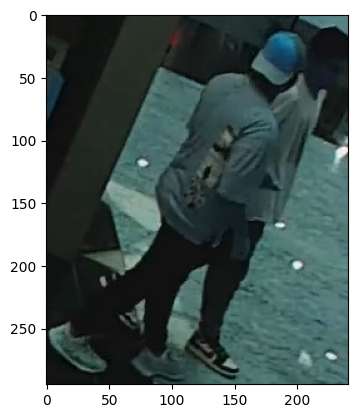

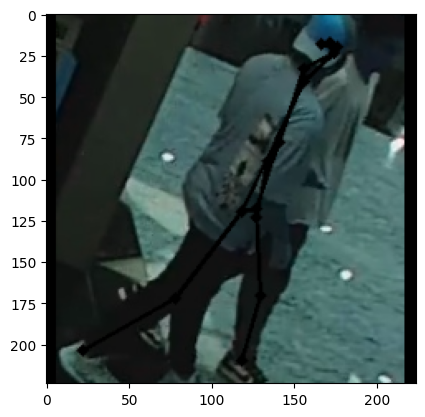

In [6]:
path = '/kaggle/input/adult-child-v2-train-val-test/Adult_Child_v2 train_val_test/test/Adult/ch1_NVR_ch1_main_20220820210000_20220820220000.mp4_000698bf-a7f8-4572-be6d-6e39b5ee8195.jpg'
import cv2
import matplotlib.pyplot as plt

# Read the image
img = cv2.imread(path)

# Display the original image
plt.imshow(img)
plt.show()

# Apply the preprocess function
processed_img = preprocess_image_add_pose_keypoints(img)

# Display the processed image
plt.imshow(processed_img/255)
plt.show()

In [25]:
train_path = '/kaggle/input/adult-child-v2-train-val-test/Adult_Child_v2 train_val_test/train'
validation_path = '/kaggle/input/adult-child-v2-train-val-test/Adult_Child_v2 train_val_test/val'
test_path = '/kaggle/input/adult-child-v2-train-val-test/Adult_Child_v2 train_val_test/test'

############################################################################################################################################
# Create a data generator to load and augment the training data
#Removed rescale from Image data generators, since Using pre
train_datagen_without_preprocessing = ImageDataGenerator(  
    #rescale=1.0/255,  #If using the pre processing fn of the pre trainde models, no need to rescale, and should add featurewise_center=False if so.
    featurewise_center=False, # if using the pre processing of the pre trained models, no need to make featurewise center, and if not false, should fit it before use
    rotation_range=20,  # randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # randomly shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # randomly shift images vertically by up to 20% of the image height
    shear_range=0.2,  # randomly shear images by up to 20%
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False,  # do not randomly flip images vertically
    fill_mode='nearest'
)

train_generator_without_preprocessing = train_datagen_without_preprocessing.flow_from_directory(
    train_path,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)
# Create a data generator to load the validation data
val_datagen_without_preprocessing = ImageDataGenerator( featurewise_center=False)

val_generator_without_preprocessing = val_datagen_without_preprocessing.flow_from_directory(
    validation_path,
    target_size= (img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
shuffle=False)

#######################################################################################################################################
# Create a data generator to accept the trainign data with the preprocessing function
train_datagen_with_preprocessing = ImageDataGenerator(
    featurewise_center=False,
     rotation_range=20,  # randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # randomly shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # randomly shift images vertically by up to 20% of the image height
    shear_range=0.2,  # randomly shear images by up to 20%
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False,  # do not randomly flip images vertically
    fill_mode='nearest',  # fill any missing pixels with the nearest value
    #preprocessing_function=preprocess_image_add_pose_keypoints  # apply the preprocessing function
    preprocessing_function=lambda x: preprocess_image_add_pose_keypoints(x, movenet,
                                                                         image_output_shape=(img_width, img_height),
                                                                         confidence_threshold= 0.05)
)

train_generator_with_preprocessing = train_datagen_with_preprocessing.flow_from_directory(
    train_path,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


# Create a data generator to load the validation data with the preprocessing function
val_datagen_with_preprocessing = ImageDataGenerator( 
    featurewise_center=False,
    #preprocessing_function=preprocess_image_add_pose_keypoints  # apply the preprocessing function
    preprocessing_function=lambda x: preprocess_image_add_pose_keypoints(x, movenet, 
                                                      image_output_shape=(img_width, img_height),confidence_threshold=0.05)
)

val_generator_with_preprocessing = val_datagen_with_preprocessing.flow_from_directory(
    validation_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

#######################################################################################################################################
test_datagen_without_preprocessing = ImageDataGenerator( featurewise_center=False,)

#Load the training data
test_generator_without_preprocessing = test_datagen_without_preprocessing.flow_from_directory(
    test_path,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
###################################
# Create a data generator to accept the trainign data with the preprocessing function
test_datagen_with_preprocessing = ImageDataGenerator( featurewise_center=False,
    #preprocessing_function=preprocess_image_add_pose_keypoints  # apply the preprocessing function
    preprocessing_function=lambda x: preprocess_image_add_pose_keypoints(x, movenet, 
                                                      image_output_shape=(img_width, img_height),confidence_threshold= 0.05)
)

# Load the training data
test_generator_with_preprocessing = test_datagen_with_preprocessing.flow_from_directory(
    test_path,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5642 images belonging to 2 classes.
Found 720 images belonging to 2 classes.
Found 5642 images belonging to 2 classes.
Found 720 images belonging to 2 classes.
Found 674 images belonging to 2 classes.
Found 674 images belonging to 2 classes.


# First Approach

## Without Pose Estimation key points

### Train before Tune

In [11]:
train_generator = train_generator_without_preprocessing
val_generator = val_generator_without_preprocessing
test_generator = test_generator_without_preprocessing
preprocess_fn = mobilenet_preprocess

neurons_final = 1024
base_model = create_base_MobileNetV2()
fine_tune_limit = len(base_model.layers) - int(0.1*len(base_model.layers))
model_name= 'MobileNetV2'
fine_tuning = 'before_tuning'
keypoints_added = 'without_keypoints'

epochs_1 = 10
epochs_fine_tuning = 20
epcohs_8 = 8
epochs_30 = 30
lr_1 = 1e-3
lr_2 = 1e-5
print("Done")
##########################################################################

base_model.trainable = False
inputs = Input(shape=(224,224,3))
x = preprocess_fn(inputs) 
#Run base model in Inference mode by passing training=false,This is important for fine-tuning.
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(neurons_final, activation='relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
print("Model Summary: " , model.summary())

Done
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                             

In [12]:
counter = Counter(train_generator.classes)
print(str(counter.items())+"\n") # dict_items([(0, 1648), (1, 3614)])
Adult = 3997
Child = 1645
total = Adult + Child
weight_for_Adult =   (total / Adult) 
weight_for_Child =   (total /Child)
weight_for_Adult /= (weight_for_Adult +  weight_for_Child)
weight_for_Child /= (weight_for_Adult +  weight_for_Child)

class_weight = {0: weight_for_Adult, 1: weight_for_Child}
print('Class Weights: ', class_weight)
###################################################################################################
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

dict_items([(0, 3997), (1, 1645)])

Class Weights:  {0: 0.2915632754342432, 1: 0.9216512191765469}


In [13]:
call_backs = [EarlyStopping(monitor='val_loss', patience=6),
              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)]

model.compile(optimizer=Adam(learning_rate=lr_1), loss= 'binary_crossentropy', metrics=METRICS)

steps_per_epoch = train_generator.n // batch_size  
validation_steps = val_generator.n // batch_size
print("Training Started\n")   
###################################################################################################
history = model.fit(train_generator,
                    epochs=epochs_1,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=call_backs,
                    validation_data=val_generator,
                    class_weight=class_weight)
print("Training Finished\n") 
###################################################################################################

Training Started

Epoch 1/10
88/88 [==============================] - 88s 940ms/step - loss: 0.2739 - tp: 1348.0000 - fp: 589.0000 - tn: 3408.0000 - fn: 233.0000 - accuracy: 0.8526 - precision: 0.6959 - recall: 0.8526 - auc: 0.9013 - prc: 0.6965 - val_loss: 0.5018 - val_tp: 184.0000 - val_fp: 164.0000 - val_tn: 353.0000 - val_fn: 3.0000 - val_accuracy: 0.7628 - val_precision: 0.5287 - val_recall: 0.9840 - val_auc: 0.9815 - val_prc: 0.9598 - lr: 0.0010
Epoch 2/10
88/88 [==============================] - 79s 897ms/step - loss: 0.1055 - tp: 1462.0000 - fp: 464.0000 - tn: 3533.0000 - fn: 119.0000 - accuracy: 0.8955 - precision: 0.7591 - recall: 0.9247 - auc: 0.9693 - prc: 0.9419 - val_loss: 0.1188 - val_tp: 171.0000 - val_fp: 17.0000 - val_tn: 500.0000 - val_fn: 16.0000 - val_accuracy: 0.9531 - val_precision: 0.9096 - val_recall: 0.9144 - val_auc: 0.9893 - val_prc: 0.9758 - lr: 0.0010
Epoch 3/10
88/88 [==============================] - 76s 866ms/step - loss: 0.0888 - tp: 1471.0000 - fp: 37

In [14]:
# delete_folder_contents('/kaggle/working/')

In [ ]:
################################################################################################################
plot_save_results(model, model_name, fine_tuning, keypoints_added, epochs_1, batch_size, history)

path ='/kaggle/working/{}'.format(model_name)
name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs_1)+'epochs'
zip_delete(name, path)

#plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
model.save('/kaggle/working/{}.h5'.format(name))
saved_model_before_wihoutKPts_path = '/kaggle/working/{}.h5'.format(name)
print(saved_model_before_wihoutKPts_path)

In [ ]:
# model.load_weights('/kaggle/working/RESNet-50_without_keypoints_before_tuning_10epochs.h5')
# model.compile(optimizer=Adam(learning_rate=lr_2), loss= 'binary_crossentropy', metrics=METRICS)

In [15]:
###########################################################################################################
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator_without_preprocessing.reset()
model.evaluate(test_generator)



Evaluation of test Data Generator:


11/11 [==============================] - 7s 643ms/step - loss: 0.0673 - tp: 190.0000 - fp: 14.0000 - tn: 468.0000 - fn: 2.0000 - accuracy: 0.9763 - precision: 0.9314 - recall: 0.9896 - auc: 0.9977 - prc: 0.9947          


[0.06732417643070221,
 190.0,
 14.0,
 468.0,
 2.0,
 0.9762611389160156,
 0.9313725233078003,
 0.9895833134651184,
 0.9977254271507263,
 0.9946621656417847]

### Fine Tuning

In [16]:
print_parameters_count(base_model)

Total params: 2,257,984.0
Trainable params: 0.0
Non-trainable params: 2,257,984


In [17]:
base_model.trainable = True
for layer in base_model.layers[:fine_tune_limit]:
    layer.trainable=False
print_parameters_count(base_model)
###################################################################################################
model.compile(optimizer=Adam(learning_rate=lr_2), loss= 'binary_crossentropy', metrics=METRICS)
print('#######################################################################\n')
print(model.summary())

Total params: 2,257,984
Trainable params: 1,040,000
Non-trainable params: 1,217,984
#######################################################################

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                  

Epoch 1/20
89/89 [==============================] - 86s 865ms/step - loss: 0.0490 - tp: 1789.0000 - fp: 219.0000 - tn: 4260.0000 - fn: 48.0000 - accuracy: 0.9577 - precision: 0.8909 - recall: 0.9739 - auc: 0.9930 - prc: 0.9833 - val_loss: 0.0791 - val_tp: 194.0000 - val_fp: 11.0000 - val_tn: 506.0000 - val_fn: 9.0000 - val_accuracy: 0.9722 - val_precision: 0.9463 - val_recall: 0.9557 - val_auc: 0.9955 - val_prc: 0.9856
Epoch 2/20
89/89 [==============================] - 77s 862ms/step - loss: 0.0353 - tp: 1616.0000 - fp: 148.0000 - tn: 3849.0000 - fn: 29.0000 - accuracy: 0.9686 - precision: 0.9161 - recall: 0.9824 - auc: 0.9965 - prc: 0.9913 - val_loss: 0.0849 - val_tp: 195.0000 - val_fp: 13.0000 - val_tn: 504.0000 - val_fn: 8.0000 - val_accuracy: 0.9708 - val_precision: 0.9375 - val_recall: 0.9606 - val_auc: 0.9956 - val_prc: 0.9858
Epoch 3/20
89/89 [==============================] - 77s 864ms/step - loss: 0.0363 - tp: 1607.0000 - fp: 166.0000 - tn: 3831.0000 - fn: 38.0000 - accuracy:

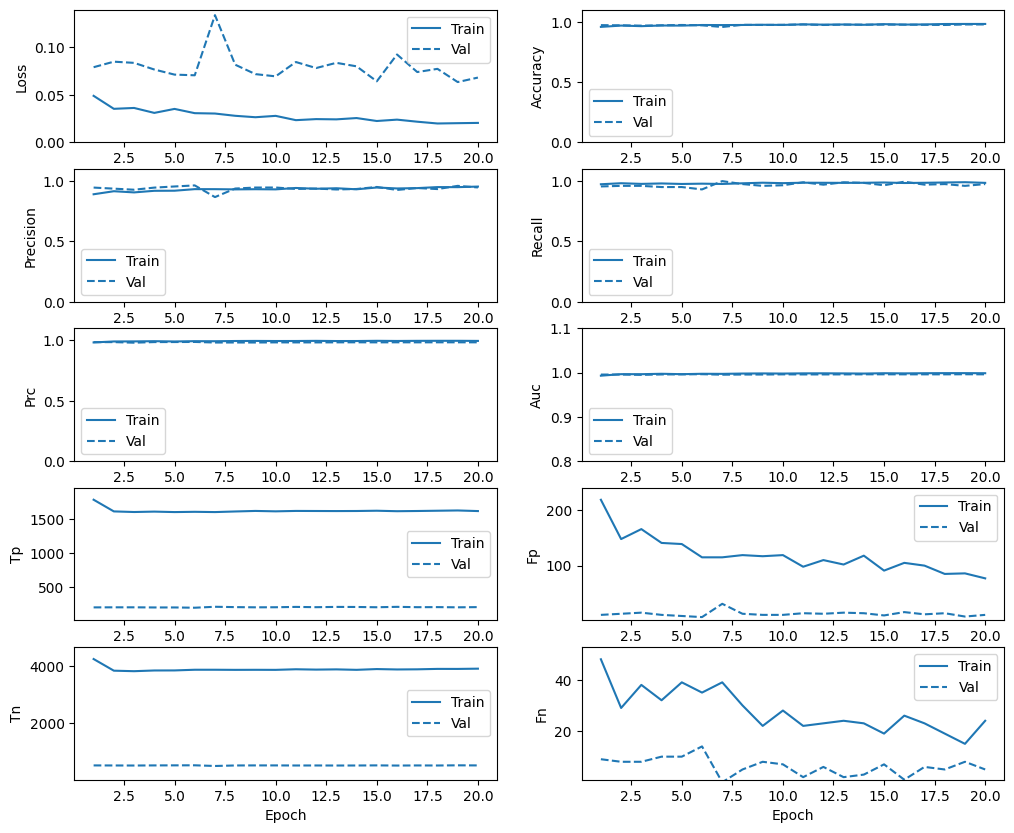

In [18]:
call_backs_2 = [EarlyStopping(monitor='val_loss',patience=6)]
history_after_tune = model.fit(train_generator,
                              epochs=epochs_fine_tuning,
                              callbacks=call_backs_2 ,
                              validation_data=val_generator,
                              class_weight=class_weight)
fine_tuning = 'after_tuning'
###########################################################################################################
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator_without_preprocessing.reset()
model.evaluate(test_generator)
################################################################################################################
plot_save_results(model, model_name, fine_tuning, keypoints_added, epochs_fine_tuning, batch_size, history_after_tune)

path ='/kaggle/working/{}'.format(model_name)
name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs_fine_tuning)+'epochs'
zip_delete(name, path)

#plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
model.save('/kaggle/working/{}.h5'.format(name))

## With Pose Estimation key points

### Train before Tune

In [27]:
train_generator = train_generator_with_preprocessing
val_generator = val_generator_with_preprocessing
test_generator = test_generator_with_preprocessing
preprocess_fn = mobilenet_preprocess
neurons_final = 1024
base_model = create_base_MobileNetV2()
fine_tune_limit = len(base_model.layers) - int(0.1 * len(base_model.layers))
model_name= 'MobileNetV2'
fine_tuning = 'before_tuning'
keypoints_added = 'with_keypoints'

epochs_1 = 10
epochs_fine_tuning = 20
epcohs_8 = 8
epochs_30 = 30
lr_1 = 1e-3
lr_2 = 1e-5
print("Done")

#####################################################################3
base_model.trainable = False

inputs = Input(shape=(224,224,3))
# x = PreprocessAddKPts()(inputs)
x = preprocess_fn(inputs)
#Run base model in Inference mode by passing training=false,This is important for fine-tuning.
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(neurons_final, activation='relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
print( model.summary())

Done
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                             

Training Started


Epoch 1/10
89/89 [==============================] - 226s 2s/step - loss: 0.2534 - tp: 1922.0000 - fp: 950.0000 - tn: 4306.0000 - fn: 313.0000 - accuracy: 0.8314 - precision: 0.6692 - recall: 0.8600 - auc: 0.9215 - prc: 0.8814 - val_loss: 0.2299 - val_tp: 189.0000 - val_fp: 55.0000 - val_tn: 462.0000 - val_fn: 14.0000 - val_accuracy: 0.9042 - val_precision: 0.7746 - val_recall: 0.9310 - val_auc: 0.9767 - val_prc: 0.9621 - lr: 0.0010
Epoch 2/10
89/89 [==============================] - 189s 2s/step - loss: 0.1355 - tp: 1437.0000 - fp: 466.0000 - tn: 3531.0000 - fn: 208.0000 - accuracy: 0.8805 - precision: 0.7551 - recall: 0.8736 - auc: 0.9493 - prc: 0.9168 - val_loss: 0.1894 - val_tp: 191.0000 - val_fp: 35.0000 - val_tn: 482.0000 - val_fn: 12.0000 - val_accuracy: 0.9347 - val_precision: 0.8451 - val_recall: 0.9409 - val_auc: 0.9831 - val_prc: 0.9700 - lr: 0.0010
Epoch 3/10
89/89 [==============================] - 190s 2s/step - loss: 0.0982 - tp: 1501.0000 - fp: 335.000

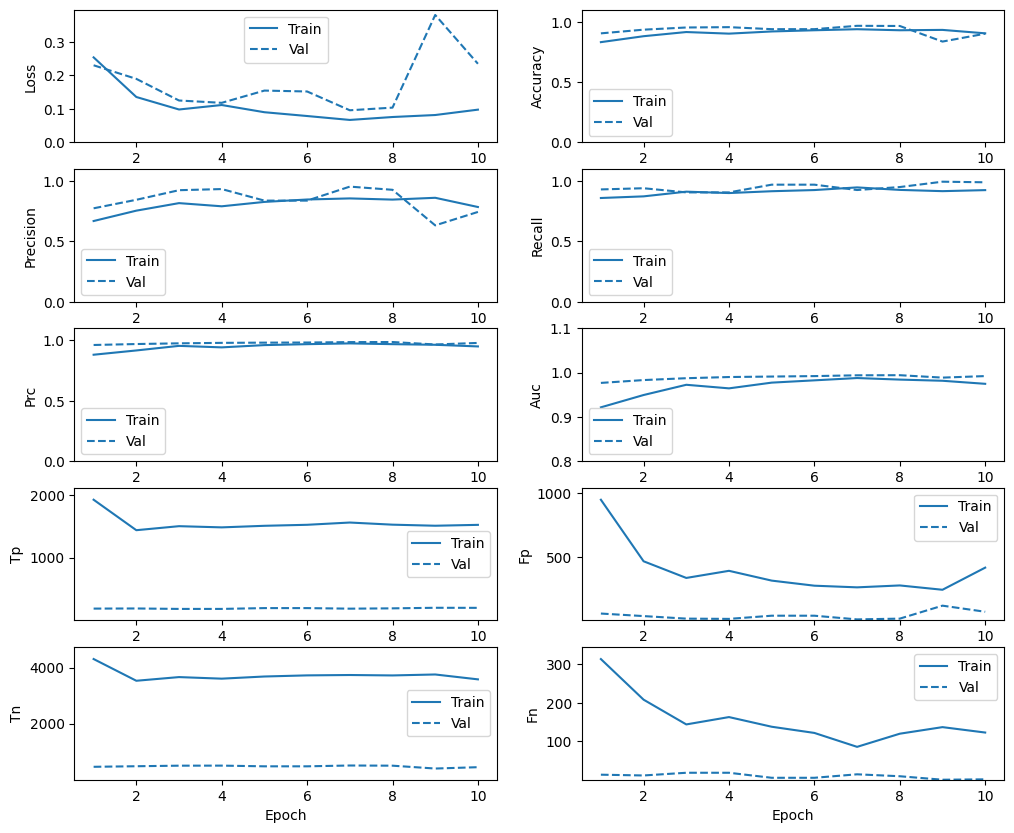

In [28]:
call_backs = [ EarlyStopping(monitor='val_loss', patience=6),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5) ]

model.compile(optimizer=Adam(learning_rate=lr_1),loss= 'binary_crossentropy',metrics=METRICS)

# steps_per_epoch = train_generator.n // batch_size  
# validation_steps = val_generator.n // batch_size
print("Training Started\n\n")   
train_generator.reset()
val_generator.reset()
history = model.fit(train_generator,
                    epochs= epochs_1,
                    callbacks=call_backs,
                    validation_data=val_generator,
                    class_weight=class_weight)
print("Training Finished\n")

##################################################################################
plot_save_results(model, model_name, fine_tuning, keypoints_added, epochs_1, batch_size, history)

path ='/kaggle/working/{}'.format(model_name)
name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs_1)+'epochs'
zip_delete(name, path)

#plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
model.save('/kaggle/working/{}.h5'.format(name))

In [29]:
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator_without_preprocessing.reset()
model.evaluate(test_generator)



Evaluation of test Data Generator:


11/11 [==============================] - 18s 2s/step - loss: 0.2036 - tp: 191.0000 - fp: 63.0000 - tn: 419.0000 - fn: 1.0000 - accuracy: 0.9050 - precision: 0.7520 - recall: 0.9948 - auc: 0.9959 - prc: 0.9911            


[0.20360060036182404,
 191.0,
 63.0,
 419.0,
 1.0,
 0.9050444960594177,
 0.751968502998352,
 0.9947916865348816,
 0.9958506226539612,
 0.991100549697876]

In [ ]:
# saved_model_before_withKPts_path = '/kaggle/working/{}.h5'.format(name)
# print(saved_model_before_withKPts_path)

### Fine Tuning

In [ ]:
# model.load_weights('/kaggle/working/RESNet-50_with_keypoints_before_tuning_10epochs.h5')

In [ ]:
# model.compile(optimizer=Adam(learning_rate=lr_1),loss= 'binary_crossentropy',metrics=METRICS)
# model.evaluate(test_generator)

In [30]:
fine_tuning = 'after_tuning'
base_model.trainable = True
for layer in base_model.layers[:fine_tune_limit]:
    layer.trainable=False


model.compile(optimizer=Adam(learning_rate=lr_2),loss= 'binary_crossentropy',metrics=METRICS)
print('+===================================')
print_parameters_count(model)
print(model.summary())

+===================================
Total params: 3,570,753
Trainable params: 2,352,769
Non-trainable params: 1,217,984
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 glo

Epoch 1/20
89/89 [==============================] - 197s 2s/step - loss: 0.0654 - tp: 1736.0000 - fp: 300.0000 - tn: 4179.0000 - fn: 101.0000 - accuracy: 0.9365 - precision: 0.8527 - recall: 0.9450 - auc: 0.9886 - prc: 0.9777 - val_loss: 0.1314 - val_tp: 198.0000 - val_fp: 34.0000 - val_tn: 483.0000 - val_fn: 5.0000 - val_accuracy: 0.9458 - val_precision: 0.8534 - val_recall: 0.9754 - val_auc: 0.9944 - val_prc: 0.9870
Epoch 2/20
89/89 [==============================] - 189s 2s/step - loss: 0.0553 - tp: 1585.0000 - fp: 230.0000 - tn: 3767.0000 - fn: 60.0000 - accuracy: 0.9486 - precision: 0.8733 - recall: 0.9635 - auc: 0.9917 - prc: 0.9824 - val_loss: 0.0959 - val_tp: 194.0000 - val_fp: 20.0000 - val_tn: 497.0000 - val_fn: 9.0000 - val_accuracy: 0.9597 - val_precision: 0.9065 - val_recall: 0.9557 - val_auc: 0.9952 - val_prc: 0.9886
Epoch 3/20
89/89 [==============================] - 192s 2s/step - loss: 0.0523 - tp: 1574.0000 - fp: 174.0000 - tn: 3823.0000 - fn: 71.0000 - accuracy: 0.95

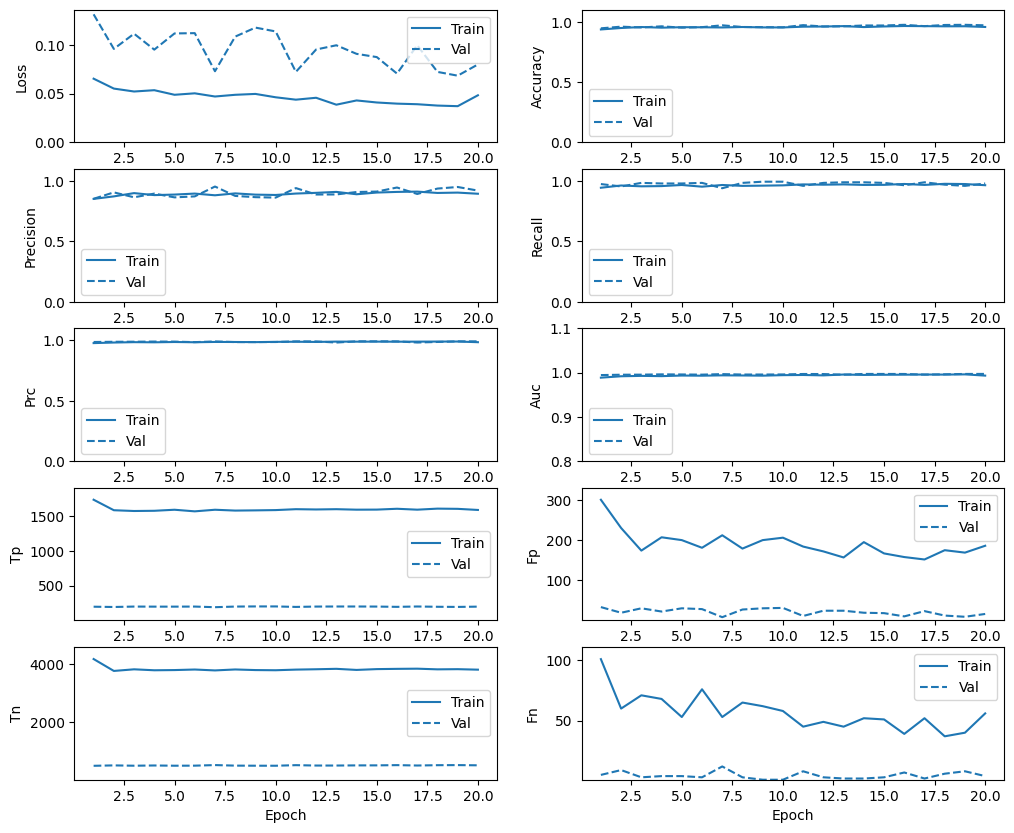

In [31]:
#######################################################################################################################33
call_backs_2 = [EarlyStopping(monitor='val_loss',patience=6)]
steps_per_epoch = train_generator.n // batch_size  
validation_steps = val_generator.n // batch_size
history_after_tune = model.fit(train_generator,
                              epochs=epochs_fine_tuning,
                               #steps_per_epoch=steps_per_epoch,
                              callbacks=call_backs_2 ,
                              validation_data=val_generator,
                               #validation_steps=validation_steps,
                              class_weight=class_weight)

#############################################################################################################33
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator_without_preprocessing.reset()
model.evaluate(test_generator)

##########################################################################################################
plot_save_results(model, model_name, fine_tuning, keypoints_added, epochs_fine_tuning, batch_size, history_after_tune)

path ='/kaggle/working/{}'.format(model_name)
name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs_fine_tuning)+'epochs'
zip_delete(name, path)

#plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
model.save('/kaggle/working/{}.h5'.format(name))

# Second Approach: Unfreeze all layers 

In [7]:
#define generators from second data set
#reapeat trainning of dense layers before unfreezing the model
train_path = '/kaggle/input/adult-child-small-train-test-split/Adult_Child_v2 small_copy train_val_test/train'
validation_path = '/kaggle/input/adult-child-small-train-test-split/Adult_Child_v2 small_copy train_val_test/val'
test_path = '/kaggle/input/adult-child-small-train-test-split/Adult_Child_v2 small_copy train_val_test/test'

############################################################################################################################################
# Create a data generator to load and augment the training data
train_datagen_without_preprocessing_2 = ImageDataGenerator(  
    #rescale=1.0/255,  #If using the pre processing fn of the pre trainde models, no need to rescale, and should add featurewise_center=False if so.
    featurewise_center=False, # if using the pre processing of the pre trained models, no need to make featurewise center, and if not false, should fit it before use
    rotation_range=20,  # randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # randomly shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # randomly shift images vertically by up to 20% of the image height
    shear_range=0.2,  # randomly shear images by up to 20%
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False,  # do not randomly flip images vertically
    fill_mode='nearest' )

train_generator_without_preprocessing_2 = train_datagen_without_preprocessing_2.flow_from_directory(
    train_path,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False )
# Create a data generator to load the validation data
val_datagen_without_preprocessing_2 = ImageDataGenerator( featurewise_center=False)

val_generator_without_preprocessing_2 = val_datagen_without_preprocessing_2.flow_from_directory(
    validation_path,
    target_size= (img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
shuffle=False )

#######################################################################################################################################
# Create a data generator to accept the trainign data with the preprocessing function
train_datagen_with_preprocessing_2 = ImageDataGenerator(
    featurewise_center=False,
     rotation_range=20,  # randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # randomly shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # randomly shift images vertically by up to 20% of the image height
    shear_range=0.2,  # randomly shear images by up to 20%
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False,  # do not randomly flip images vertically
    fill_mode='nearest',  # fill any missing pixels with the nearest value
    #preprocessing_function=preprocess_image_add_pose_keypoints  # apply the preprocessing function
    preprocessing_function=lambda x: preprocess_image_add_pose_keypoints(x, movenet,
                                                                         image_output_shape=(img_width, img_height),
                                                                         confidence_threshold= 0.05) )

train_generator_with_preprocessing_2 = train_datagen_with_preprocessing_2.flow_from_directory(
    train_path,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False )

# Create a data generator to load the validation data with the preprocessing function
val_datagen_with_preprocessing_2 = ImageDataGenerator( 
    featurewise_center=False,
    #preprocessing_function=preprocess_image_add_pose_keypoints  # apply the preprocessing function
    preprocessing_function=lambda x: preprocess_image_add_pose_keypoints(x, movenet, 
                                                      image_output_shape=(img_width, img_height),confidence_threshold=0.05) )

val_generator_with_preprocessing_2 = val_datagen_with_preprocessing_2.flow_from_directory(
    validation_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False )

#######################################################################################################################################
test_datagen_without_preprocessing_2 = ImageDataGenerator( featurewise_center=False,)

#Load the training data
test_generator_without_preprocessing_2 = test_datagen_without_preprocessing_2.flow_from_directory(
    test_path,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False )
###################################
# Create a data generator to accept the trainign data with the preprocessing function
test_datagen_with_preprocessing_2 = ImageDataGenerator( featurewise_center=False,
    #preprocessing_function=preprocess_image_add_pose_keypoints  # apply the preprocessing function
    preprocessing_function=lambda x: preprocess_image_add_pose_keypoints(x, movenet, 
                                                      image_output_shape=(img_width, img_height),confidence_threshold= 0.05) )

# Load the training data
test_generator_with_preprocessing_2 = test_datagen_with_preprocessing_2.flow_from_directory(
    test_path,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False )

Found 2535 images belonging to 2 classes.
Found 1882 images belonging to 2 classes.
Found 2535 images belonging to 2 classes.
Found 1882 images belonging to 2 classes.
Found 1849 images belonging to 2 classes.
Found 1849 images belonging to 2 classes.


## Wihtout Pose Estimation

In [8]:
train_generator = train_generator_without_preprocessing_2
val_generator = val_generator_without_preprocessing_2
test_generator = test_generator_without_preprocessing_2
#############################################################
preprocess_fn = mobilenet_preprocess############################
neurons_final = 1024########################################
base_model = create_base_MobileNetV2()###########################
# fine_tune_limit = len(base_model.layers) - int(0.1 * len(base_model.layers))-1
model_name= 'MobileNetV2_approach2'#################################
fine_tuning = 'before_tuning'################################
keypoints_added = 'without_keypoints'
###############################################################
epochs_1 = 10
epochs_fine_tuning = 20
epochs_8 = 8
epochs_40 = 40
lr_1 = 1e-3
lr_2 = 1e-5
print("Done")
##########################################################################
base_model.trainable = False
inputs = Input(shape=(224,224,3))
x = preprocess_fn(inputs) 
#Run base model in Inference mode by passing training=false,This is important for fine-tuning.
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(neurons_final, activation='relu')(x)###########################################
x = Dropout(0.5)(x)
outputs =  Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
print("Model Summary: " , model.summary())

9406464/9406464 [==============================] - 0s 0us/step
Done
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0   

In [9]:
counter = Counter(train_generator.classes)
print(str(counter.items())+"\n") # dict_items([(0, 1648), (1, 3614)])
Adult = 3997
Child = 1645
total = Adult + Child
weight_for_Adult =   (total / Adult) 
weight_for_Child =   (total /Child)
weight_for_Adult /= (weight_for_Adult +  weight_for_Child)
weight_for_Child /= (weight_for_Adult +  weight_for_Child)

class_weight = {0: weight_for_Adult, 1: weight_for_Child}
print('Class Weights: ', class_weight)

METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR'), ]  # precision-recall curve 

dict_items([(0, 1691), (1, 844)])

Class Weights:  {0: 0.2915632754342432, 1: 0.9216512191765469}


Training Started

Epoch 1/10
40/40 [==============================] - 63s 1s/step - loss: 0.8697 - tp: 705.0000 - fp: 536.0000 - tn: 1155.0000 - fn: 139.0000 - accuracy: 0.7337 - precision: 0.5681 - recall: 0.8353 - auc: 0.8163 - prc: 0.7125 - val_loss: 0.3586 - val_tp: 483.0000 - val_fp: 45.0000 - val_tn: 1231.0000 - val_fn: 123.0000 - val_accuracy: 0.9107 - val_precision: 0.9148 - val_recall: 0.7970 - val_auc: 0.9667 - val_prc: 0.9487 - lr: 0.0010
Epoch 2/10
40/40 [==============================] - 39s 972ms/step - loss: 0.1874 - tp: 724.0000 - fp: 311.0000 - tn: 1380.0000 - fn: 120.0000 - accuracy: 0.8300 - precision: 0.6995 - recall: 0.8578 - auc: 0.9069 - prc: 0.8644 - val_loss: 0.2919 - val_tp: 580.0000 - val_fp: 171.0000 - val_tn: 1105.0000 - val_fn: 26.0000 - val_accuracy: 0.8953 - val_precision: 0.7723 - val_recall: 0.9571 - val_auc: 0.9792 - val_prc: 0.9658 - lr: 0.0010
Epoch 3/10
40/40 [==============================] - 38s 959ms/step - loss: 0.1116 - tp: 771.0000 - fp: 169.

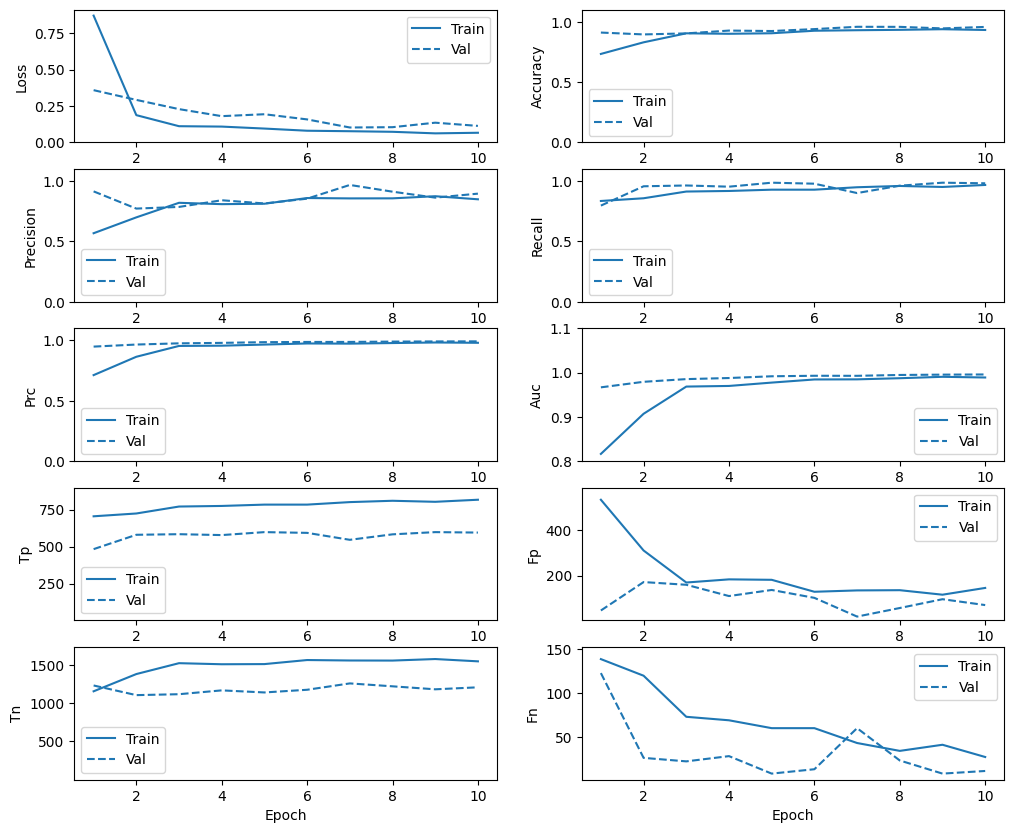

In [10]:
base_model.trainable = False
#Train dense layers:
call_backs = [EarlyStopping(monitor='val_loss', patience=6),
              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)]

model.compile(optimizer=Adam(learning_rate=lr_1), loss= 'binary_crossentropy', metrics=METRICS )

steps_per_epoch = train_generator.n // batch_size  
validation_steps = val_generator.n // batch_size
print("Training Started\n")   
#############################################################################
history = model.fit(train_generator,
                    epochs=epochs_1,
                    callbacks=call_backs,
                    validation_data=val_generator,
                    class_weight=class_weight)
print("Training Finished\n") 
###############################################################################

################################################################################################################
model_name= 'MobileNetV2_approach2'
fine_tuning = 'before_tuning'
keypoints_added = 'without_keypoints'

plot_save_results(model, model_name, fine_tuning, keypoints_added, epochs_1, batch_size, history)

path ='/kaggle/working/{}'.format(model_name)
name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs_1)+'epochs'
zip_delete(name, path)

#plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
model.save('/kaggle/working/{}.h5'.format(name))
saved_model_before_wihoutKPts_path = '/kaggle/working/{}.h5'.format(name)
print(saved_model_before_wihoutKPts_path)

In [11]:
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model.evaluate(test_generator)



Evaluation of test Data Generator:


29/29 [==============================] - 14s 502ms/step - loss: 0.1151 - tp: 577.0000 - fp: 65.0000 - tn: 1194.0000 - fn: 13.0000 - accuracy: 0.9578 - precision: 0.8988 - recall: 0.9780 - auc: 0.9952 - prc: 0.9908


[0.11507663130760193,
 577.0,
 65.0,
 1194.0,
 13.0,
 0.9578150510787964,
 0.8987538814544678,
 0.9779661297798157,
 0.9951919317245483,
 0.9908332824707031]

In [12]:
base_model.trainable = True
# for layer in base_model.layers[:fine_tune_limit]:
#     layer.trainable=False
    
model.compile(optimizer=Adam(learning_rate=lr_2),loss= 'binary_crossentropy',metrics=METRICS)
print('===================================')
print_parameters_count(model)
print(model.summary())


Total params: 3,570,753
Trainable params: 3,536,641
Non-trainable params: 34,112
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)    

### Fine Tuning 8 epcohs

Epoch 1/8
40/40 [==============================] - 72s 1s/step - loss: 0.0647 - tp: 1372.0000 - fp: 156.0000 - tn: 2794.0000 - fn: 62.0000 - accuracy: 0.9503 - precision: 0.8979 - recall: 0.9568 - auc: 0.9919 - prc: 0.9857 - val_loss: 0.1332 - val_tp: 600.0000 - val_fp: 104.0000 - val_tn: 1172.0000 - val_fn: 6.0000 - val_accuracy: 0.9416 - val_precision: 0.8523 - val_recall: 0.9901 - val_auc: 0.9961 - val_prc: 0.9928
Epoch 2/8
40/40 [==============================] - 42s 1s/step - loss: 0.0524 - tp: 823.0000 - fp: 119.0000 - tn: 1572.0000 - fn: 21.0000 - accuracy: 0.9448 - precision: 0.8737 - recall: 0.9751 - auc: 0.9932 - prc: 0.9879 - val_loss: 0.1580 - val_tp: 602.0000 - val_fp: 127.0000 - val_tn: 1149.0000 - val_fn: 4.0000 - val_accuracy: 0.9304 - val_precision: 0.8258 - val_recall: 0.9934 - val_auc: 0.9966 - val_prc: 0.9938
Epoch 3/8
40/40 [==============================] - 41s 1s/step - loss: 0.0471 - tp: 818.0000 - fp: 78.0000 - tn: 1613.0000 - fn: 26.0000 - accuracy: 0.9590 - p

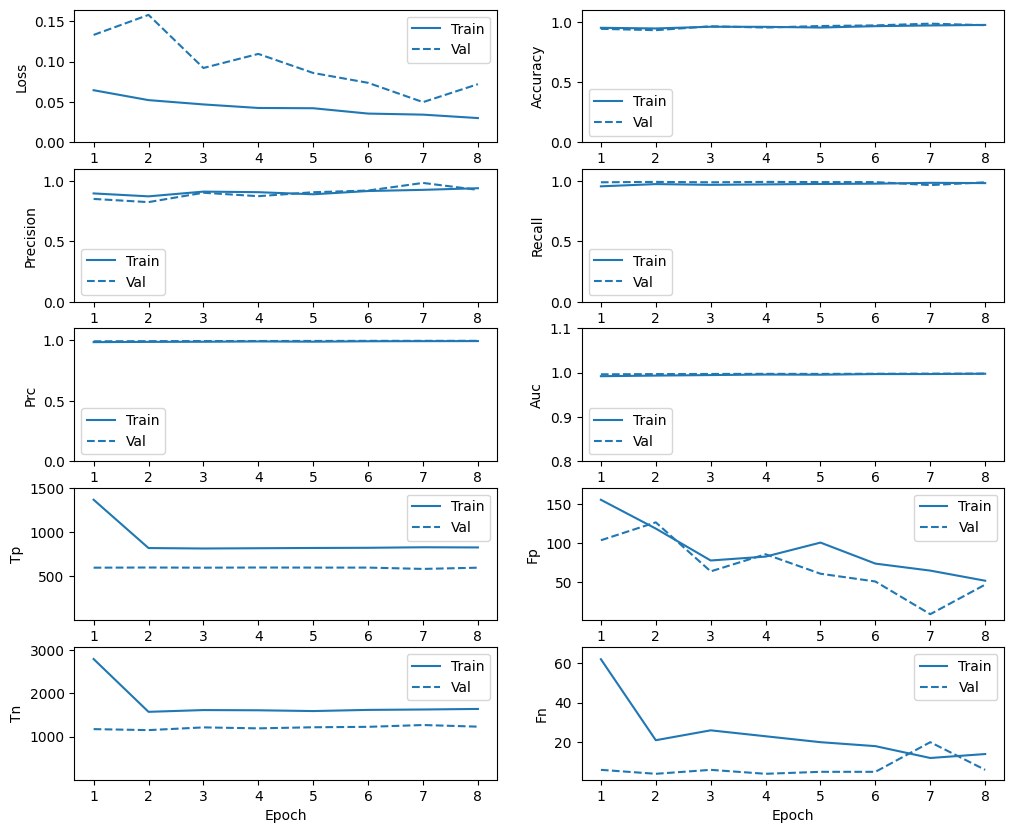

In [13]:
call_backs_2 = [EarlyStopping(monitor='val_loss',patience=6)]
history_after_tune = model.fit(train_generator,
                              epochs=epochs_8,
                              callbacks=call_backs_2 ,
                              validation_data=val_generator,
                              class_weight=class_weight)
fine_tuning = 'after_tuning_8'
###########################################################################################################
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model.evaluate(test_generator)

################################################################################################################
model_name= 'RESNet-50_approach2'#################################
fine_tuning = 'tuning_8epochs'
keypoints_added = 'without_keypoints'

plot_save_results(model, model_name, fine_tuning, keypoints_added, epochs_8, batch_size, history_after_tune)

path ='/kaggle/working/{}'.format(model_name)
name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs_8)+'epochs'
zip_delete(name, path)

#plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
model.save('/kaggle/working/{}.h5'.format(name))

### Fine Tuning 40

In [ ]:
call_backs_2 = [EarlyStopping(monitor='val_loss',patience=6)]
history_after_tune2 = model.fit(train_generator,
                              epochs=epochs_40,
                              callbacks=call_backs_2 ,
                              validation_data=val_generator,
                              class_weight=class_weight)
###########################################################################################################




Evaluation of test Data Generator:


29/29 [==============================] - 6s 194ms/step - loss: 0.0568 - tp: 586.0000 - fp: 29.0000 - tn: 1230.0000 - fn: 4.0000 - accuracy: 0.9822 - precision: 0.9528 - recall: 0.9932 - auc: 0.9972 - prc: 0.9927    


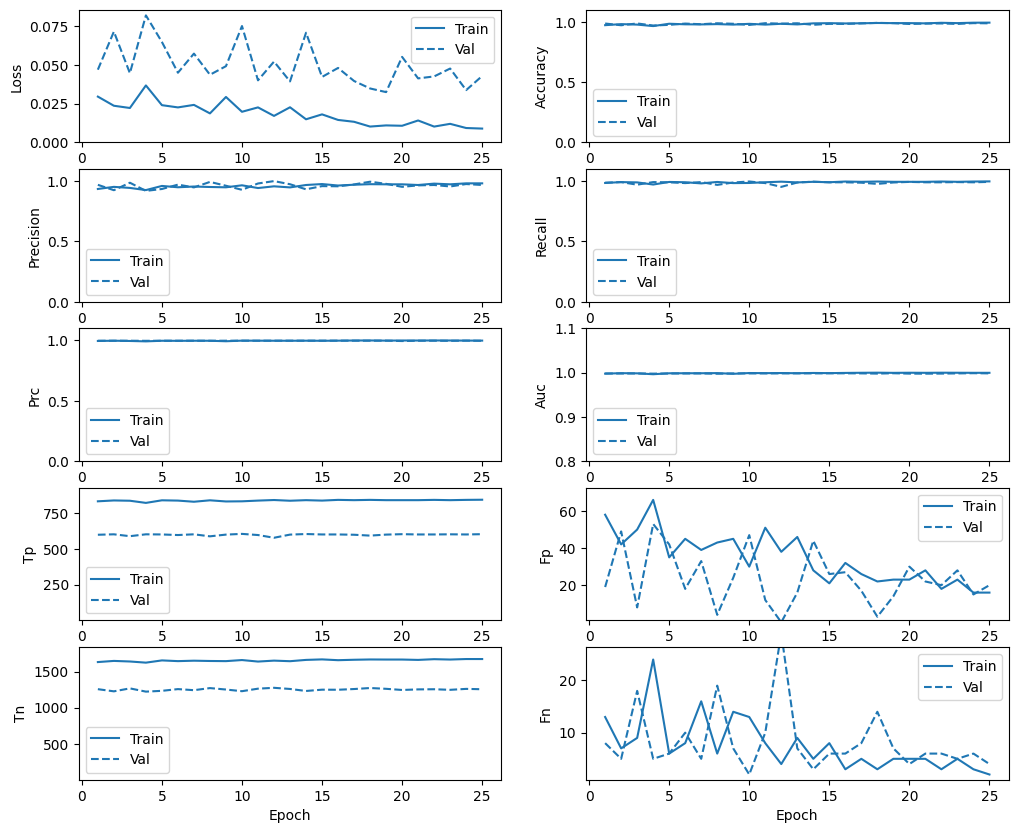

In [16]:
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model.evaluate(test_generator)

################################################################################################################
model_name= 'MobileNetV2_approach2'
fine_tuning = 'tuning_40epochs'
keypoints_added = 'without_keypoints'
plot_save_results(model, model_name, fine_tuning, keypoints_added, epochs_40, batch_size, history_after_tune2)

path ='/kaggle/working/{}'.format(model_name)
name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs_40)+'epochs'
zip_delete(name, path)

#plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
model.save('/kaggle/working/{}.h5'.format(name))

## With Pose Estimation

In [17]:
train_generator = train_generator_with_preprocessing_2
val_generator = val_generator_with_preprocessing_2
test_generator = test_generator_with_preprocessing_2
preprocess_fn = mobilenet_preprocess
neurons_final = 1024
base_model = create_base_MobileNetV2()
fine_tune_limit = len(base_model.layers) - int(0.1 * len(base_model.layers))-1
model_name= 'MobileNetV2_approach2'#################################
fine_tuning = 'before_tuning'
keypoints_added = 'without_keypoints'

epochs_1 = 10
epochs_fine_tuning = 20
epcohs_8 = 8
epochs_40 = 40
lr_1 = 1e-3
lr_2 = 1e-5
print("Done")
##########################################################################
base_model.trainable = False
inputs = Input(shape=(224,224,3))
x = preprocess_fn(inputs) 
#Run base model in Inference mode by passing training=false,This is important for fine-tuning.
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(neurons_final, activation='relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
print("Model Summary: " , model.summary())

Done
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                             

Training Started

Epoch 1/10
40/40 [==============================] - 119s 3s/step - loss: 1.9741 - tp: 1166.0000 - fp: 906.0000 - tn: 2044.0000 - fn: 268.0000 - accuracy: 0.7322 - precision: 0.5627 - recall: 0.8131 - auc: 0.8180 - prc: 0.7634 - val_loss: 0.3968 - val_tp: 547.0000 - val_fp: 141.0000 - val_tn: 1135.0000 - val_fn: 59.0000 - val_accuracy: 0.8937 - val_precision: 0.7951 - val_recall: 0.9026 - val_auc: 0.9620 - val_prc: 0.9480 - lr: 0.0010
Epoch 2/10
40/40 [==============================] - 117s 3s/step - loss: 0.1736 - tp: 716.0000 - fp: 274.0000 - tn: 1417.0000 - fn: 128.0000 - accuracy: 0.8414 - precision: 0.7232 - recall: 0.8483 - auc: 0.9152 - prc: 0.9036 - val_loss: 0.2882 - val_tp: 558.0000 - val_fp: 106.0000 - val_tn: 1170.0000 - val_fn: 48.0000 - val_accuracy: 0.9182 - val_precision: 0.8404 - val_recall: 0.9208 - val_auc: 0.9754 - val_prc: 0.9644 - lr: 0.0010
Epoch 3/10
40/40 [==============================] - 109s 3s/step - loss: 0.1454 - tp: 762.0000 - fp: 314.00

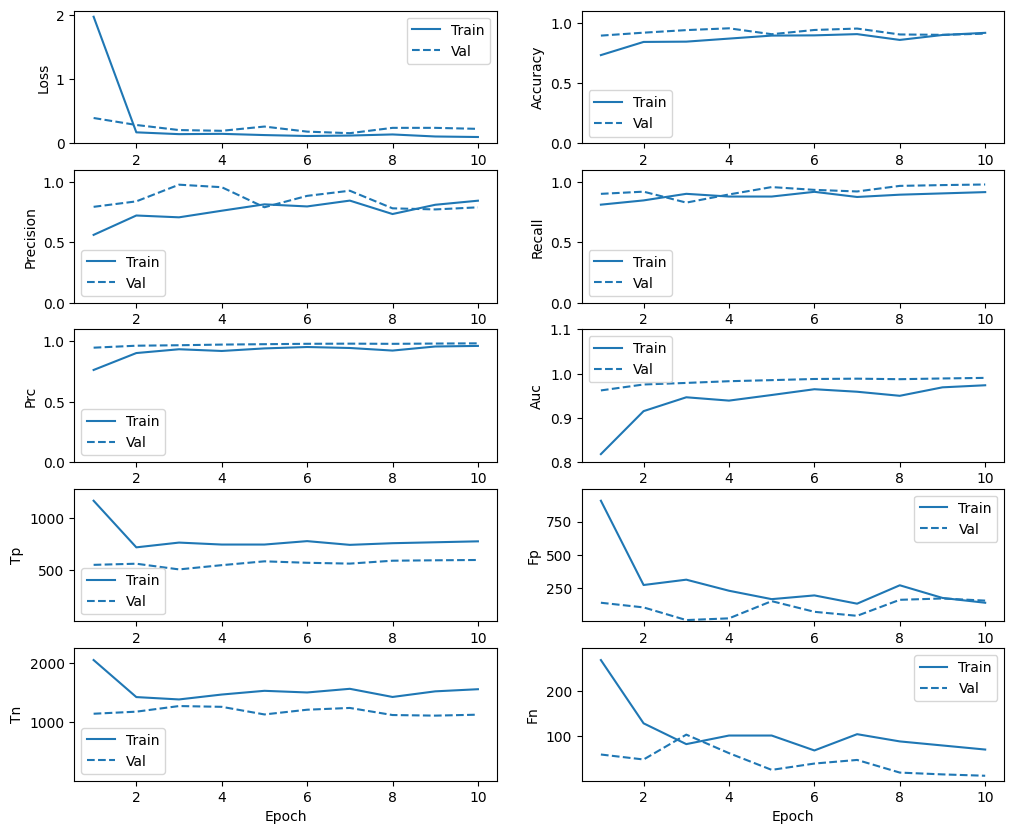

In [18]:
#Load weights
# model.load_weights('/kaggle/input/vgg19-before-tuning/BeforeFineTuning/VGG19__with_keypoints__before_tuning__10epcohs__64batch.h5')

#Train dense layers
base_model.trainable = False
#Train dense layers:
call_backs = [EarlyStopping(monitor='val_loss', patience=6),
              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)]

model.compile(optimizer=Adam(learning_rate=lr_1), loss= 'binary_crossentropy', metrics=METRICS)

# steps_per_epoch = train_generator.n // batch_size  
# validation_steps = val_generator.n // batch_size
print("Training Started\n")   
#############################################################################
history = model.fit(train_generator,
                    epochs=epochs_1,
                    callbacks=call_backs,
                    validation_data=val_generator,
                    class_weight=class_weight)
print("Training Finished\n") 
###############################################################################
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model.evaluate(test_generator)
################################################################################################################
model_name= 'RESNet-50_approach2'#################################
fine_tuning = 'before_tuning'
keypoints_added = 'with_keypoints'
plot_save_results(model, model_name, fine_tuning, keypoints_added, epochs_1, batch_size, history)

path ='/kaggle/working/{}'.format(model_name)
name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs_1)+'epochs'
zip_delete(name, path)

#plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
model.save('/kaggle/working/{}.h5'.format(name))
saved_model_before_wihoutKPts_path = '/kaggle/working/{}.h5'.format(name)
print(saved_model_before_wihoutKPts_path)

In [19]:
base_model.trainable = True
# for layer in base_model.layers[:fine_tune_limit]:
#     layer.trainable=False
    
model.compile(optimizer=Adam(learning_rate=lr_2),loss= 'binary_crossentropy',metrics=METRICS)
print('===================================')
print_parameters_count(model)
print(model.summary())

Total params: 3,570,753
Trainable params: 3,536,641
Non-trainable params: 34,112
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)  

### Fine Tuning 8 epochs

Epoch 1/8
40/40 [==============================] - 141s 3s/step - loss: 0.0981 - tp: 1340.0000 - fp: 271.0000 - tn: 2679.0000 - fn: 94.0000 - accuracy: 0.9167 - precision: 0.8318 - recall: 0.9344 - auc: 0.9788 - prc: 0.9696 - val_loss: 0.2507 - val_tp: 599.0000 - val_fp: 172.0000 - val_tn: 1104.0000 - val_fn: 7.0000 - val_accuracy: 0.9049 - val_precision: 0.7769 - val_recall: 0.9884 - val_auc: 0.9918 - val_prc: 0.9861
Epoch 2/8
40/40 [==============================] - 118s 3s/step - loss: 0.0920 - tp: 784.0000 - fp: 152.0000 - tn: 1539.0000 - fn: 60.0000 - accuracy: 0.9164 - precision: 0.8376 - recall: 0.9289 - auc: 0.9788 - prc: 0.9691 - val_loss: 0.1256 - val_tp: 576.0000 - val_fp: 49.0000 - val_tn: 1227.0000 - val_fn: 30.0000 - val_accuracy: 0.9580 - val_precision: 0.9216 - val_recall: 0.9505 - val_auc: 0.9926 - val_prc: 0.9873
Epoch 3/8
40/40 [==============================] - 116s 3s/step - loss: 0.0835 - tp: 797.0000 - fp: 152.0000 - tn: 1539.0000 - fn: 47.0000 - accuracy: 0.9215

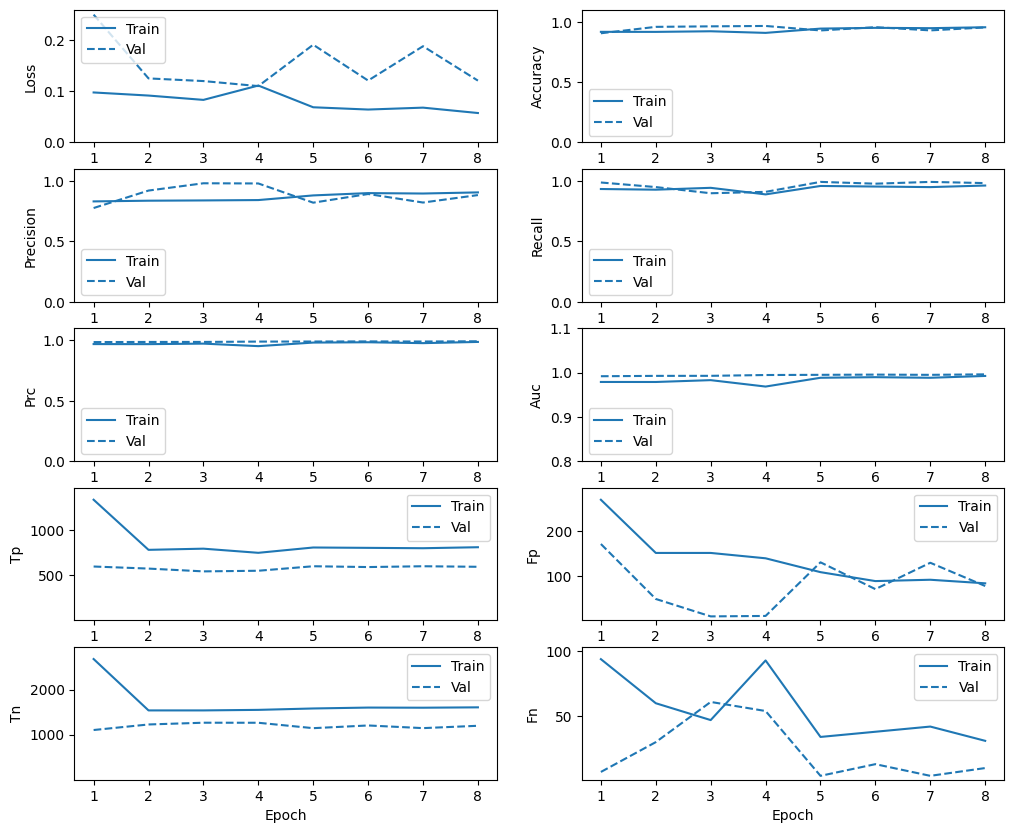

In [20]:
call_backs_2 = [EarlyStopping(monitor='val_loss',patience=6)]
history_after_tune = model.fit(train_generator,
                              epochs=epochs_8,
                              callbacks=call_backs_2 ,
                              validation_data=val_generator,
                              class_weight=class_weight)
fine_tuning = 'after_tuning_8'
###########################################################################################################
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model.evaluate(test_generator)

################################################################################################################
model_name= 'MobileNetV2_approach2'#################################
fine_tuning = 'tuning_8epochs'
keypoints_added = 'with_keypoints'
plot_save_results(model, model_name, fine_tuning, keypoints_added, epochs_8, batch_size, history_after_tune)

path ='/kaggle/working/{}'.format(model_name)
name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs_8)+'epochs'
zip_delete(name, path)

#plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
model.save('/kaggle/working/{}.h5'.format(name))

### Fine Tuning 40

Epoch 1/40
40/40 [==============================] - 115s 3s/step - loss: 0.0499 - tp: 817.0000 - fp: 86.0000 - tn: 1605.0000 - fn: 27.0000 - accuracy: 0.9554 - precision: 0.9048 - recall: 0.9680 - auc: 0.9945 - prc: 0.9896 - val_loss: 0.0841 - val_tp: 552.0000 - val_fp: 4.0000 - val_tn: 1272.0000 - val_fn: 54.0000 - val_accuracy: 0.9692 - val_precision: 0.9928 - val_recall: 0.9109 - val_auc: 0.9959 - val_prc: 0.9928
Epoch 2/40
40/40 [==============================] - 115s 3s/step - loss: 0.0596 - tp: 806.0000 - fp: 69.0000 - tn: 1622.0000 - fn: 38.0000 - accuracy: 0.9578 - precision: 0.9211 - recall: 0.9550 - auc: 0.9905 - prc: 0.9846 - val_loss: 0.0869 - val_tp: 591.0000 - val_fp: 49.0000 - val_tn: 1227.0000 - val_fn: 15.0000 - val_accuracy: 0.9660 - val_precision: 0.9234 - val_recall: 0.9752 - val_auc: 0.9966 - val_prc: 0.9939
Epoch 3/40
40/40 [==============================] - 117s 3s/step - loss: 0.0558 - tp: 812.0000 - fp: 87.0000 - tn: 1604.0000 - fn: 32.0000 - accuracy: 0.9531 -

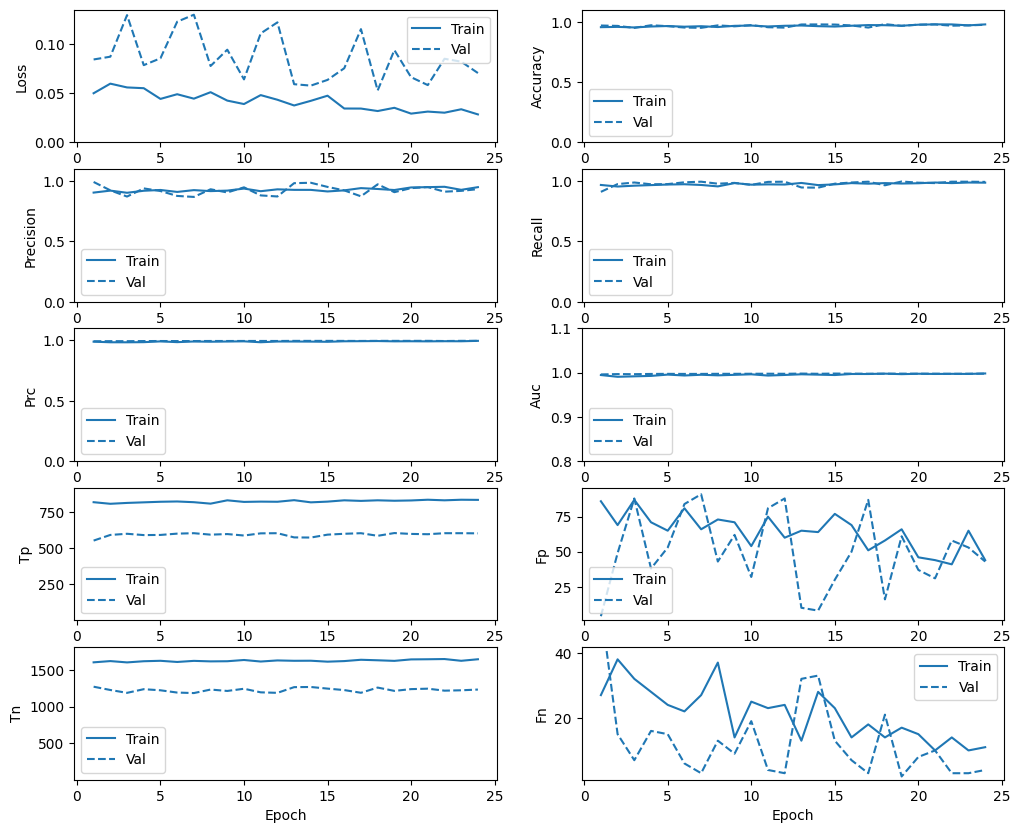

In [22]:
call_backs_2 = [EarlyStopping(monitor='val_loss',patience=6)]
history_after_tune2 = model.fit(train_generator,
                              epochs=epochs_40,
                              callbacks=call_backs_2 ,
                              validation_data=val_generator,
                              class_weight=class_weight)
fine_tuning = 'after_tuning_32'
###########################################################################################################

################################################################################################################
model_name= 'MobileNetV2_approach2'#################################
fine_tuning = 'tuning_40epochs'
keypoints_added = 'without_keypoints'
plot_save_results(model, model_name, fine_tuning, keypoints_added, epochs_40, batch_size, history_after_tune2)

path ='/kaggle/working/{}'.format(model_name)
name = model_name+'_'+keypoints_added+'_'+fine_tuning+'_'+str(epochs_40)+'epochs'
zip_delete(name, path)

#plot_save_results(model,model_name,fine_tuning,keypoints_added,epochs_1,batch_size,history)
model.save('/kaggle/working/{}.h5'.format(name))
print("Training Finished")

In [23]:
print("\n\nEvaluation of test Data Generator:\n\n")
# Evaluate the accuracy of the MobileNet_model on the test dataset using the `evaluate` method
test_generator.reset()
model.evaluate(test_generator)
print("Done")



Evaluation of test Data Generator:


29/29 [==============================] - 40s 1s/step - loss: 0.0780 - tp: 586.0000 - fp: 40.0000 - tn: 1219.0000 - fn: 4.0000 - accuracy: 0.9762 - precision: 0.9361 - recall: 0.9932 - auc: 0.9962 - prc: 0.9907         
Done
